Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Upgrad/assignment melanoma/' 

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


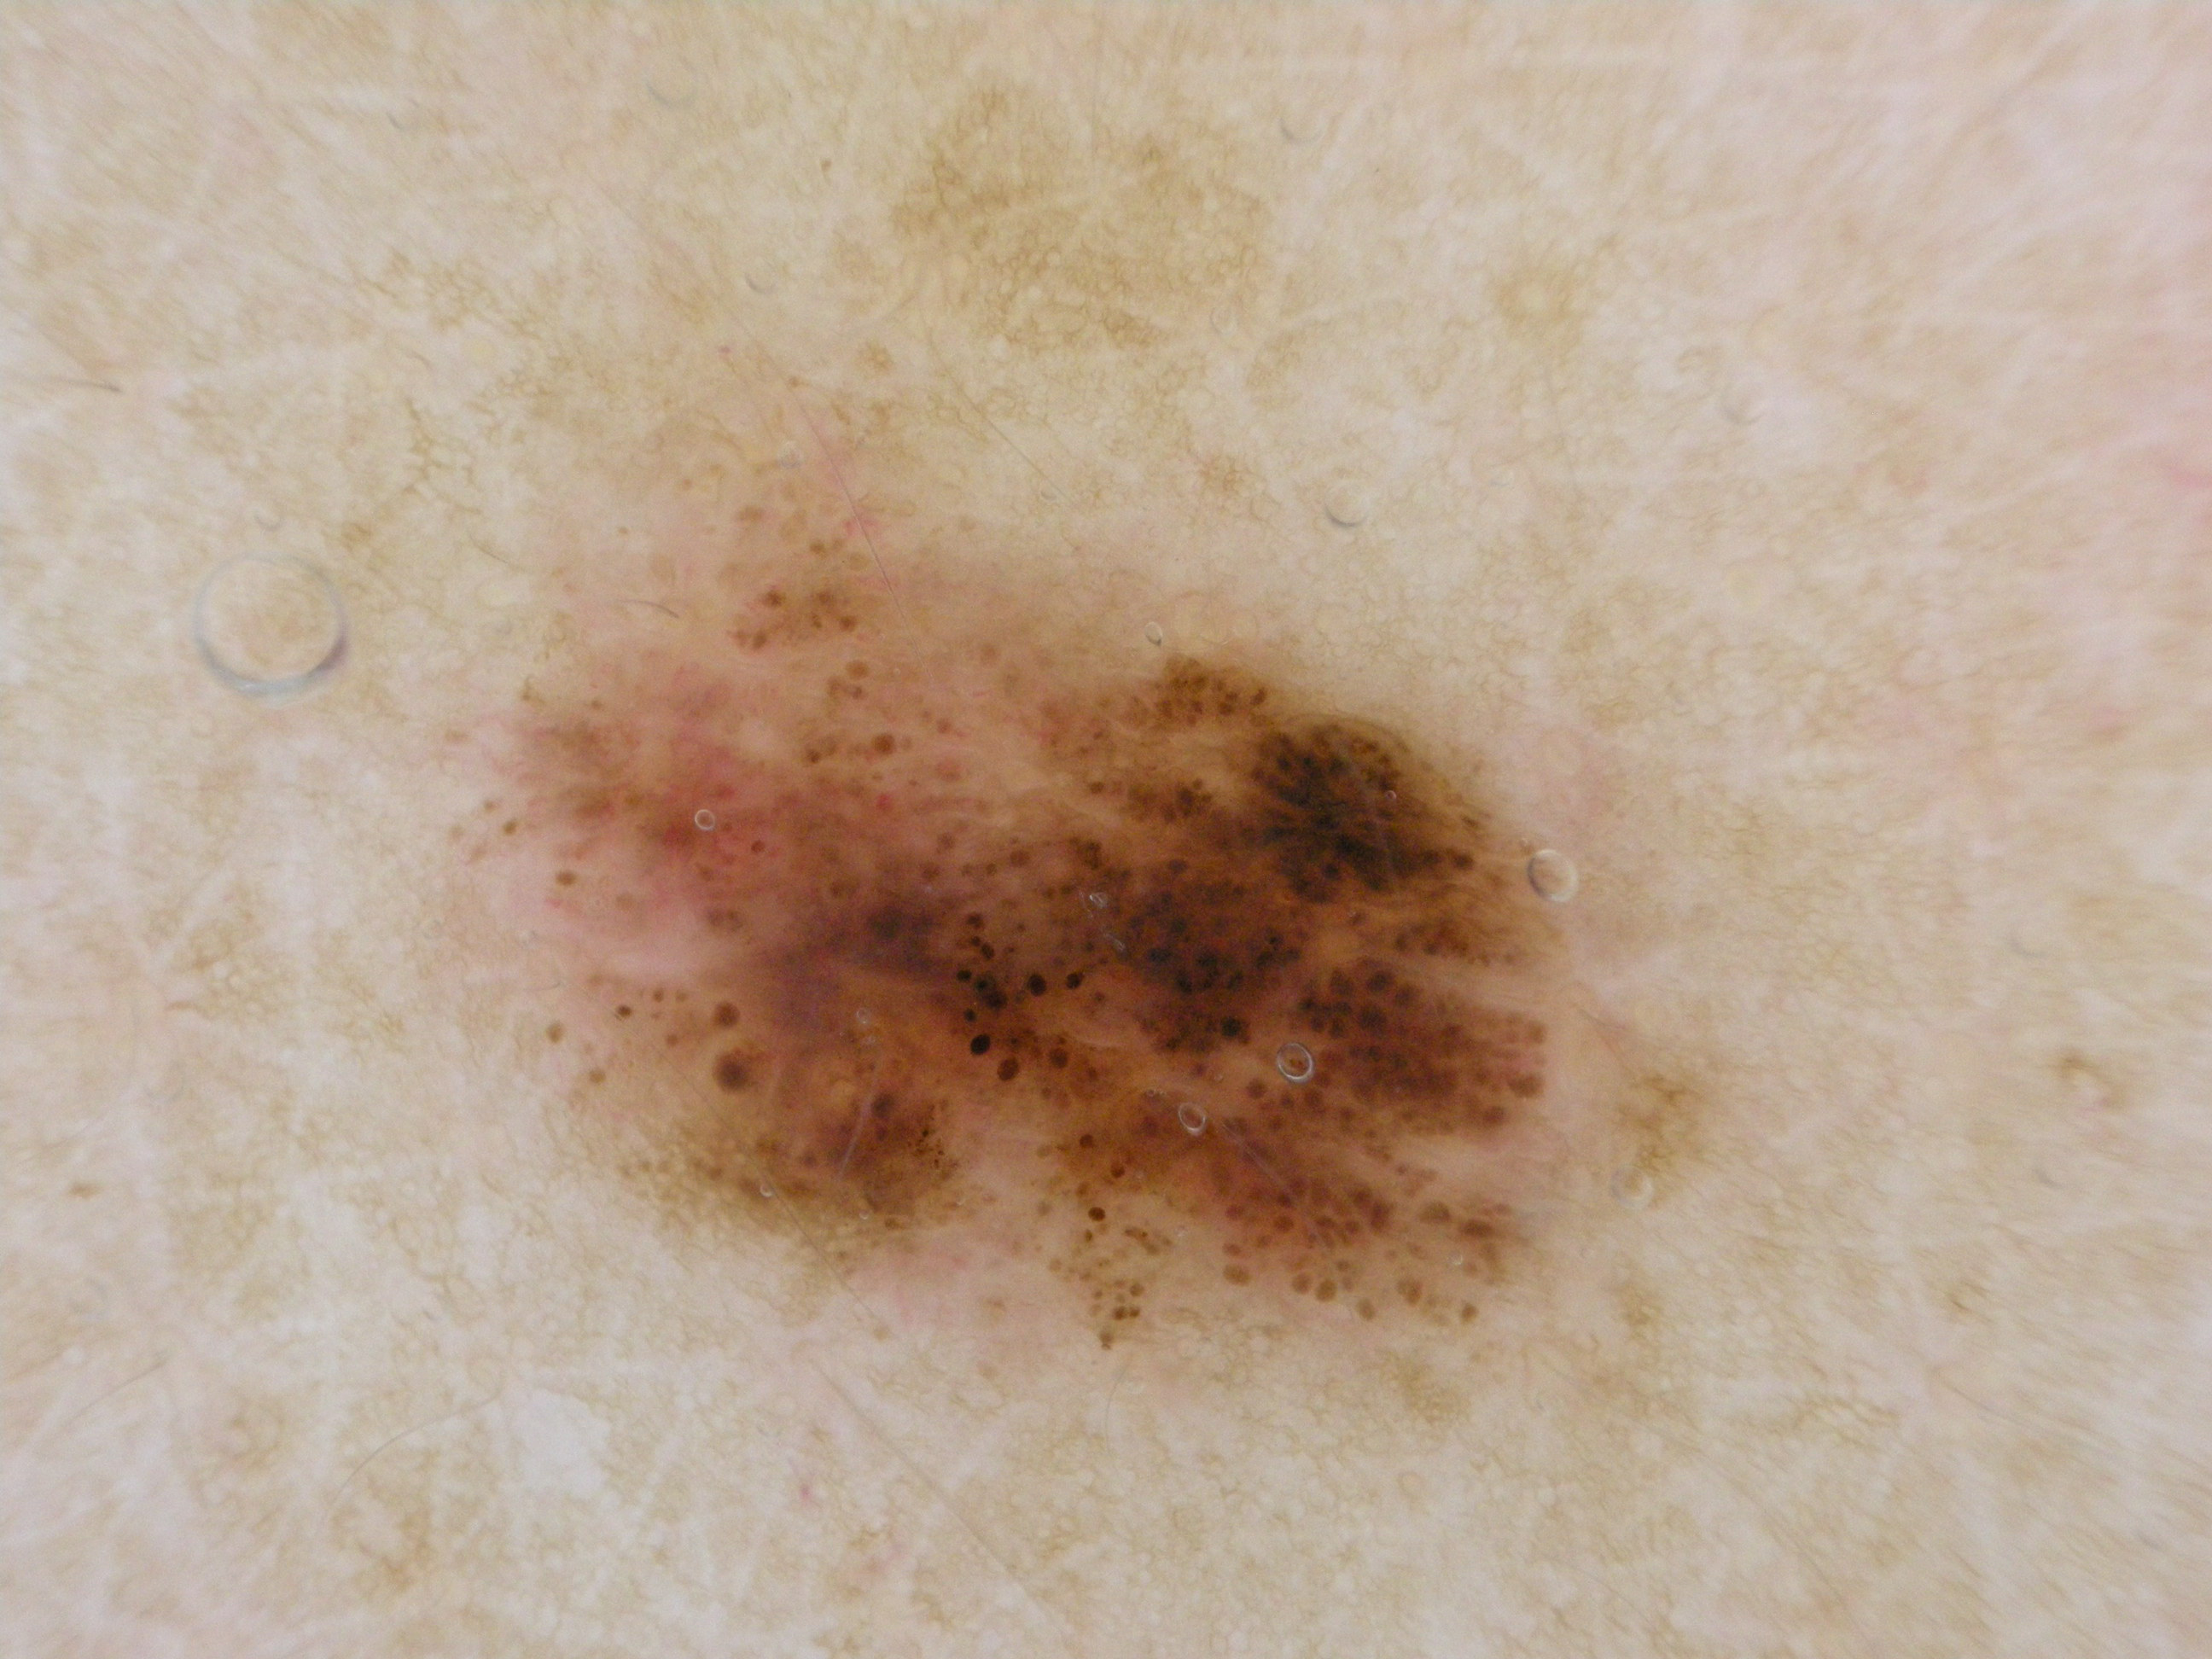

In [ ]:
#example of the first melanoma picture in the training data set
melanoma = list(data_dir_train.glob('melanoma/*'))
PIL.Image.open(str(melanoma[0]))

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

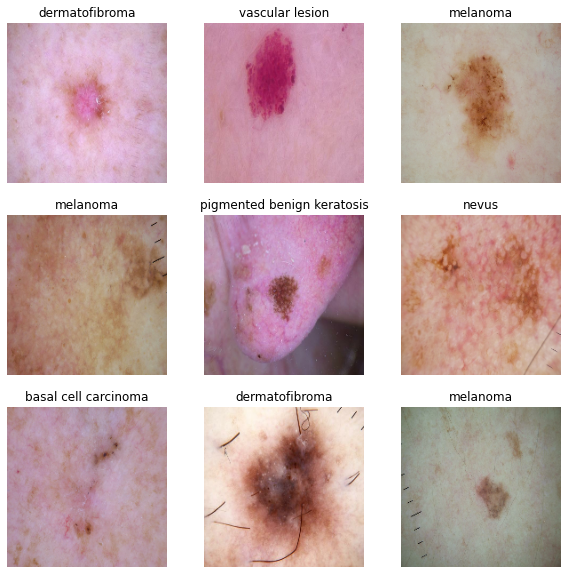

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### normalise the data
normalization_layer = layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.16879095 0.71176475


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
###  optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 111s 592ms/step - loss: 1.7598 - accuracy: 0.3429 - val_loss: 1.4382 - val_accuracy: 0.4491
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 1.3362 - accuracy: 0.4987 - val_loss: 1.2473 - val_accuracy: 0.5412
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 1.2174 - accuracy: 0.5566 - val_loss: 1.0807 - val_accuracy: 0.6192
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 0.9819 - accuracy: 0.6450 - val_loss: 1.0446 - val_accuracy: 0.6362
Epoch 5/20
169/169 [==============================] - 4s 23ms/step - loss: 0.8173 - accuracy: 0.7062 - val_loss: 0.8911 - val_accuracy: 0.6845
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 0.6768 - accuracy: 0.7639 - val_loss: 0.7805 - val_accuracy: 0.7431
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 0.5604 - accuracy: 0.8056 - val_loss: 0.7947 - val_accuracy: 0.7

### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 55% accuracy on the validation set.
The training accuracy becomes increasingly linear, while validation peaks and stalls around 50-55%. The difference between training and validation accuracy is a sign of overfitting. The training set is rather small, so that the model has learned noise or other unwanted details which then impacts the general performance the model displays on data it has not encountered before.

### Data Augmentation
Data augmentation aims to generate additional training data from already existing examples through the application of random transformations. The model is just exposed to more details of the data to help performance and its ability to generalise. Here, images are randomly flipped, rotated and zoomed to augment the data. For cancer detection, elements such as brightness and saturation are important for the disease detection. Therefore, those parameters are not going to be altered for data augmentation.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

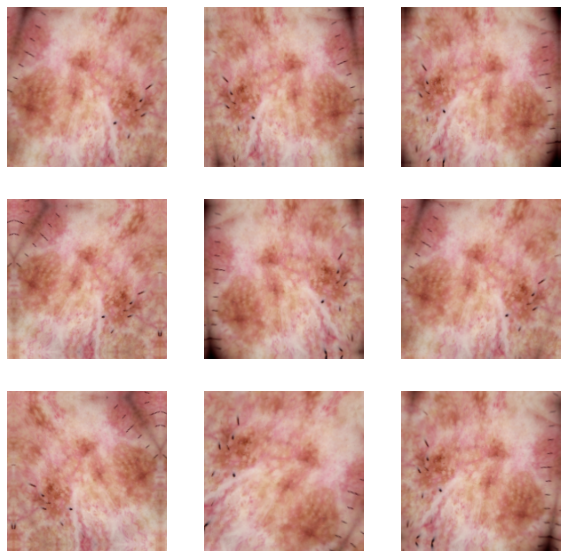

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


### Dropout layer
Here, dropout regularisation is introduced to the network. It randomly drops out a number of output units from the layer during the training process.

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 6s 27ms/step - loss: 1.9923 - accuracy: 0.2396 - val_loss: 1.6069 - val_accuracy: 0.3957
Epoch 2/20
169/169 [==============================] - 4s 26ms/step - loss: 1.5458 - accuracy: 0.3976 - val_loss: 1.3869 - val_accuracy: 0.4751
Epoch 3/20
169/169 [==============================] - 4s 26ms/step - loss: 1.4261 - accuracy: 0.4538 - val_loss: 1.2614 - val_accuracy: 0.5397
Epoch 4/20
169/169 [==============================] - 4s 26ms/step - loss: 1.3162 - accuracy: 0.5002 - val_loss: 1.2470 - val_accuracy: 0.5390
Epoch 5/20
169/169 [==============================] - 4s 26ms/step - loss: 1.2411 - accuracy: 0.5278 - val_loss: 1.3080 - val_accuracy: 0.5278
Epoch 6/20
169/169 [==============================] - 4s 26ms/step - loss: 1.1741 - accuracy: 0.5475 - val_loss: 1.1457 - val_accuracy: 0.5835
Epoch 7/20
169/169 [==============================] - 4s 26ms/step - loss: 1.1165 - accuracy: 0.5723 - val_loss: 1.0717 - val_accuracy: 0.5947

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The training and validation accuracy are closer together, hence overfitting was reduced. However, the model is now underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## display list of classes
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     gdrive/My Drive/Upgrad/assignment melanoma/Ski...  actinic keratosis
1     gdrive/My Drive/Upgrad/assignment melanoma/Ski...  actinic keratosis
2     gdrive/My Drive/Upgrad/assignment melanoma/Ski...  actinic keratosis
3     gdrive/My Drive/Upgrad/assignment melanoma/Ski...  actinic keratosis
4     gdrive/My Drive/Upgrad/assignment melanoma/Ski...  actinic keratosis
...                                                 ...                ...
2234  gdrive/My Drive/Upgrad/assignment melanoma/Ski...    vascular lesion
2235  gdrive/My Drive/Upgrad/assignment melanoma/Ski...    vascular lesion
2236  gdrive/My Drive/Upgrad/assignment melanoma/Ski...    vascular lesion
2237  gdrive/My Drive/Upgrad/assignment melanoma/Ski...    vascular lesion
2238  gdrive/My Drive/Upgrad/assignment melanoma/Ski...    vascular lesion

[2239 rows x 2 columns]

In [ ]:
## visualise classes
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

<BarContainer object of 9 artists>

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis, at under 100 samples
#### - Which classes dominate the data in terms proportionate number of samples?
Melanoma and pigmented benign keratosis have the most and proportionate number of samples at around 450


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"  +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98A7D0B0D0>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F993A084ED0>: 100%|██████████| 500/500 [00:23<00:00, 21.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F993A06B910>: 100%|██████████| 500/500 [00:21<00:00, 22.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F993A06B050>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F99305BFA50>: 100%|██████████| 500/500 [01:25<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98A7BBF210>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F993051ED50>: 100%|██████████| 500/500 [00:42<00:00, 11.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F99304E6250>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F993046AB50>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:


# data_dir_train1 = pathlib.Path("gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")

# image_count_train = len(list(data_dir_train1.glob('*/*.jpg')))
# print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_0e5a9a1e-665e-451c-84e6-5cf83f22b4c6.jpg',
 'gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_c5bf2030-4e0a-4e15-a2e5-f68e83f4d513.jpg',
 'gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_3ad1ff84-4956-4509-bede-b95537972651.jpg',
 'gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_33f23e76-250a-41fb-ba5b-ddfc5c378b9f.jpg',
 'gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collabo

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
# for i in class_names:
      
#     for j in data_dir_train.glob(i+'/*.jpg'):
#         path_list.append(str(j))
#         lesion_list.append(i)
# dataframe_dict_original = dict(zip(path_list, lesion_list))
# new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# new_df

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train1="gdrive/My Drive/Upgrad/assignment melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [43]:
epochs = 30
## Your code goes here, use 50 epochs. ## conflicting information!! The code specified 30, not 50! the live session also said 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 65s 218ms/step - loss: 2.1853 - accuracy: 0.1368 - val_loss: 2.1927 - val_accuracy: 0.1331
Epoch 2/30
281/281 [==============================] - 51s 179ms/step - loss: 2.2047 - accuracy: 0.1302 - val_loss: 2.1908 - val_accuracy: 0.1340
Epoch 3/30
281/281 [==============================] - 49s 172ms/step - loss: 2.1914 - accuracy: 0.1310 - val_loss: 2.1900 - val_accuracy: 0.1340
Epoch 4/30
281/281 [==============================] - 49s 172ms/step - loss: 2.1905 - accuracy: 0.1309 - val_loss: 2.1891 - val_accuracy: 0.1335
Epoch 5/30
281/281 [==============================] - 50s 173ms/step - loss: 2.1905 - accuracy: 0.1301 - val_loss: 2.1889 - val_accuracy: 0.1335
Epoch 6/30
281/281 [==============================] - 49s 172ms/step - loss: 2.1864 - accuracy: 0.1318 - val_loss: 2.1876 - val_accuracy: 0.1335
Epoch 7/30
281/281 [==============================] - 49s 173ms/step - loss: 2.1817 - accuracy: 0.1332 - val_loss: 2.1899 - val_accuracy: 0.1

#### **Todo:**  Visualize the model results

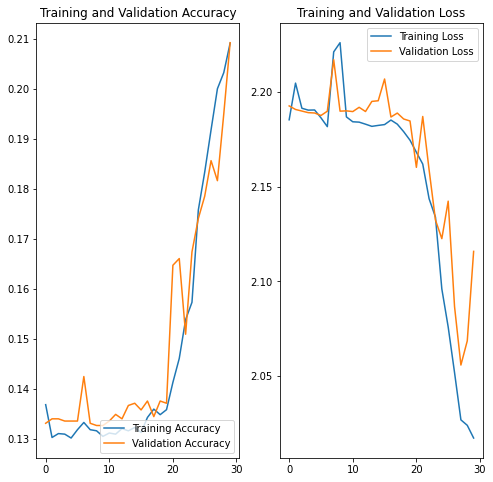

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

